Using v2 dataset. 80/20 split, no separate test. Time-based split.
This notebook is mostly based on `model-fastai-random.ipynb`.

In this case I'm skipping the experimentation in the start and will move directly to best approach in the other notebook.

**RESULT: not as good as the first one!**

In [1]:
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [2]:
path = Path("~/data/split-v2-time").expanduser()

In [3]:
data = ImageDataBunch.from_folder(path, bs=32)

It seems to be already normalized (check with `data.one_batch(DatasetType.Train)`)

This loads a model with pretrained weights (imagenet?), custom head, everything is frozen apart from the head.

In [4]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

Dropout control with `ps`, default is .5.
I think it is like keras: the probability to zero out inputs.

In [5]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


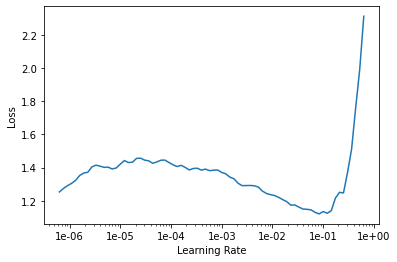

In [6]:
learn.recorder.plot()

In [5]:
learn.fit_one_cycle(1, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.248340,0.185156,0.922791,11:29


In [7]:
learn.save("model-fastai-2retry-time-1epochs")

In [6]:
learn.unfreeze()
learn.data.batch_size = 28
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


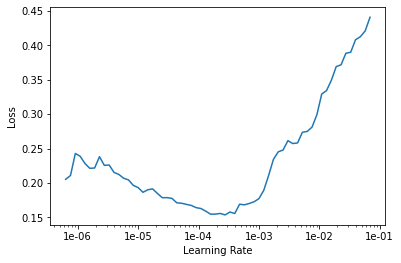

In [8]:
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(2, max_lr=[1e-6, 1e-5, 1e-4])

epoch,train_loss,valid_loss,accuracy,time
0,0.116791,0.120742,0.951163,14:04
1,0.093636,0.135081,0.943256,13:59


In [10]:
learn.save("model-fastai-2retry-time-1epoch-plus2unfrozen")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


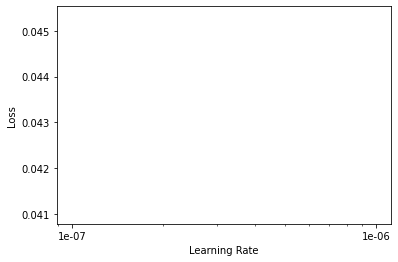

In [11]:
learn.lr_find()

Hmm, nothing to see here. Not sure what to make of that.

In [13]:
learn.fit_one_cycle(2, max_lr=[2e-6, 1e-5, 2e-5])

epoch,train_loss,valid_loss,accuracy,time
0,0.078165,0.105487,0.955349,13:58
1,0.065353,0.094821,0.965116,13:59


# Evaluate

In [14]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [15]:
accuracy(*pred_train)

tensor(0.9940)

In [16]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [17]:
accuracy(*pred_cv)

tensor(0.9651)

In [18]:
np.unique(pred_train[1], return_counts=True)

(array([0, 1]), array([7237, 1359]))

In [19]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [20]:
sklearn_metrics(pred_train)

Accuracy:  0.994
Precision: 0.974
Recall:    0.988
F1:        0.981


In [21]:
sklearn_metrics(pred_cv)

Accuracy:  0.965
Precision: 0.839
Recall:    0.965
F1:        0.897


Low-ish precision means that we are getting false positives while predicting BirdRoaming. About 1 in 10.
So sometimes we think the bird is roaming, while it's actually still there. Would be nice to get this a bit higher.